* 该脚本尝试通过Gluon实现MobileNet v1  
* 关键：实现Depthwise Convolution  
* Gluon中nn.Conv2D提供了便利的接口，即通过设置groups参数，可以指定卷积进行的方式。见下方的参数说明

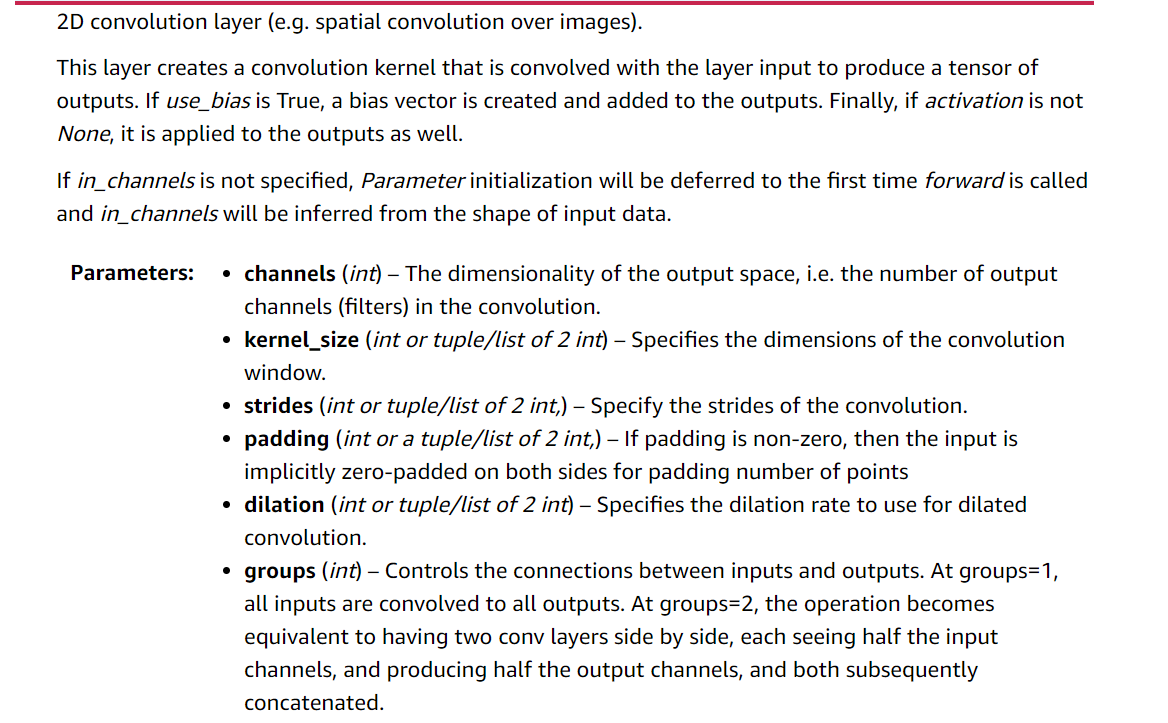

* 这个参数介绍信息量还是很大的。值得注意的有几个地方：
1. 通常一种比较省事的做法是使用Conv2D时不指定input_channels，不过这样定义完网络之后，模型的初始化会被推迟进行，即当模型第一次call forward函数时才会根据输入图像尺寸推断input_channels进而初始化网络参数。这样可能会影响model.summary()等函数的使用。  
2. 看起来Conv2D也提供了扩张卷积的接口  
3. `groups`参数：控制输入特征图和输出特征图的连接方式。默认groups=1，即卷积核的深度和输入通道深度相同。**如果取2，则效果相当于将输入特征按通道那一维分成两半，每一半与一个group进行卷积，输出的特征图concat得到一个特征图。**因此，如果将groups参数设置为同输入通道数目一致，就是Depthwise Convolution。

### Step 0: 探究Gluon中的Conv2D

In [1]:
from mxnet import nd
import numpy as np
from mxnet.gluon import nn
import mxnet as mx

* 首先我们验证下group参数是不是直接可以用来实现depthwise conv，顺便也熟悉下相关接口。  
* 思路：用一个卷积在给定输入特征上进行convolve，如果和预想的一样，则group不为1的卷积应该会输出多个通道的feature，这些feature之间element wise add的结果即为传统卷积（group=1）的输出feature map。

In [5]:
# experiment setup：定义一个输入特征图(1x4x5x5, NCHW)和一个卷积核(4x3x3)
x = np.arange(25).reshape(5,5)
X = nd.array(np.array([x]*4)).expand_dims(axis=0)
print(X.shape)
k = nd.ones((3,3)).expand_dims(axis=0)
kernel = nd.concatenate([k, 2*k, 3*k, 4*k])
print(kernel.shape)
print(X)
print(kernel)

(1, 4, 5, 5)
(4, 3, 3)

[[[[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]

  [[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]

  [[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]

  [[ 0.  1.  2.  3.  4.]
   [ 5.  6.  7.  8.  9.]
   [10. 11. 12. 13. 14.]
   [15. 16. 17. 18. 19.]
   [20. 21. 22. 23. 24.]]]]
<NDArray 1x4x5x5 @cpu(0)>

[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[2. 2. 2.]
  [2. 2. 2.]
  [2. 2. 2.]]

 [[3. 3. 3.]
  [3. 3. 3.]
  [3. 3. 3.]]

 [[4. 4. 4.]
  [4. 4. 4.]
  [4. 4. 4.]]]
<NDArray 4x3x3 @cpu(0)>


* apply普通卷积

In [3]:
# 细节：我们定义的这单层卷积有4个卷积核，但是提供的初始化是单个卷积核的初始化矩阵。所有其他卷积会共享该初始化.
# 不过这里简洁起见，只使用单个卷积核
conv_kernel = nn.Conv2D(1, kernel_size=(3,3), use_bias=False, in_channels=4)
conv_kernel.initialize(init=mx.init.Constant(kernel))
conv_kernel.forward(X)


[[[[ 540.  630.  720.]
   [ 990. 1080. 1170.]
   [1440. 1530. 1620.]]]]
<NDArray 1x1x3x3 @cpu(0)>

* apply `group=num_inchannels`的卷积

In [4]:
# 注意细节：在使用groups参数时，要求num_filters可以整除groups
depth_kernel = nn.Conv2D(4, kernel_size=(3,3), use_bias=False, groups=4, in_channels=4)
# 注意group不为1时，初始化时要求的卷积核shape其实会变化：4x3x3 -> 4x1x3x3，这就刚好符合了depthwise的定义~
# 因此这里在给init参数提供Constant kernel初始值时需要把上面定义的kernel扩充一个维度.否则报错：
# ValueError: operands could not be broadcast together with remapped shapes[original->remapped]: 
# (4, 3, 3) and requested shape (4, 1, 3, 3)
# 不过搭建网络时，即使group不为1，由于我们通常使用自带的init方式进行初始化，因此和普通卷积无异。
depth_kernel.initialize(init=mx.init.Constant(kernel.expand_dims(axis=1))) # 4个1x3x3卷积核
depthwise_output = depth_kernel.forward(X)
depth_kernel.forward(X)


[[[[ 54.  63.  72.]
   [ 99. 108. 117.]
   [144. 153. 162.]]

  [[108. 126. 144.]
   [198. 216. 234.]
   [288. 306. 324.]]

  [[162. 189. 216.]
   [297. 324. 351.]
   [432. 459. 486.]]

  [[216. 252. 288.]
   [396. 432. 468.]
   [576. 612. 648.]]]]
<NDArray 1x4x3x3 @cpu(0)>

In [5]:
### 验证普通卷积是不是group=4卷积的四个输出通道加在一起的结果
nd.sum(depthwise_output, axis=1)


[[[ 540.  630.  720.]
  [ 990. 1080. 1170.]
  [1440. 1530. 1620.]]]
<NDArray 1x3x3 @cpu(0)>

* 由于上面没有指定in_channels参数，在网络（尽管只有单个层）进行过一次forward之后，才进行了我们指定的初始化。故现在可以通过`model.weight.data()`查看卷积层权重的具体值啦！

In [6]:
# 可以非常清楚的看出来，两种卷积虽然数值一致，但卷积核维度是不同的
print(conv_kernel.weight.data())
print(depth_kernel.weight.data())


[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[2. 2. 2.]
   [2. 2. 2.]
   [2. 2. 2.]]

  [[3. 3. 3.]
   [3. 3. 3.]
   [3. 3. 3.]]

  [[4. 4. 4.]
   [4. 4. 4.]
   [4. 4. 4.]]]]
<NDArray 1x4x3x3 @cpu(0)>

[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[2. 2. 2.]
   [2. 2. 2.]
   [2. 2. 2.]]]


 [[[3. 3. 3.]
   [3. 3. 3.]
   [3. 3. 3.]]]


 [[[4. 4. 4.]
   [4. 4. 4.]
   [4. 4. 4.]]]]
<NDArray 4x1x3x3 @cpu(0)>


#### 结论  
结论就是我们可以使用Gluon提供的groups接口直接实现Depthwise Conv.不过我们需要设置：`num_in_channels(in_channels)==num_out_channels(channels)==groups`，当然同普通卷积，in_channels参数也可以不显式地指定。

### Step1: 实现Depthwise和Pointwise

In [2]:
from mxnet import gluon

In [3]:
class ConvBlock(nn.HybridBlock):
    def __init__(self, in_channels, channels, strides, padding, num_sync_bn_devices=-1, multiplier=1.0):
        super(ConvBlock, self).__init__()
        self.conv_block = nn.HybridSequential()
        with self.conv_block.name_scope():
            self.conv_block.add(nn.Conv2D(int(channels*multiplier), 3, strides, padding, 
                                          in_channels=in_channels, use_bias=False))
            if num_sync_bn_devices == -1:
                self.conv_block.add(nn.BatchNorm())
            else:
                self.conv_block.add(gluon.contrib.nn.SyncBatchNorm(num_devices=num_sync_bn_devices))
            self.conv_block.add(nn.Activation('relu'))
    def hybrid_forward(self, F, x):
        return self.conv_block(x)

class DepthwiseSeperable(nn.HybridBlock):
    def __init__(self, in_channels, channels, strides, num_sync_bn_devices=-1, multiplier=1.0, **kwags):
        # Weidth Multiplier
        in_channels = int(in_channels * multiplier)
        channels = int(channels * multiplier)
        super(DepthwiseSeperable, self).__init__(**kwags)
        self.depthwise = nn.HybridSequential()
        with self.depthwise.name_scope():
            self.depthwise.add(nn.Conv2D(in_channels, 3, strides, padding=1,groups=in_channels, 
                                         in_channels=in_channels, use_bias=False))
            if num_sync_bn_devices == -1:
                self.depthwise.add(nn.BatchNorm())
            else:
                self.depthwise.add(gluon.contrib.nn.SyncBatchNorm(num_devices=num_sync_bn_devices))
            self.depthwise.add(nn.Activation('relu'))
            
        self.pointwise = nn.HybridSequential()
        with self.pointwise.name_scope():
            self.pointwise.add(nn.Conv2D(channels, 1, in_channels=in_channels, use_bias=False))
            if num_sync_bn_devices == -1:
                self.pointwise.add(nn.BatchNorm())
            else:
                self.pointwise.add(gluon.contrib.nn.SyncBatchNorm(num_devices=num_sync_bn_devices))
            self.pointwise.add(nn.Activation('relu'))
       
    def hybrid_forward(self, F, x):
        return(self.pointwise(self.depthwise(x)))

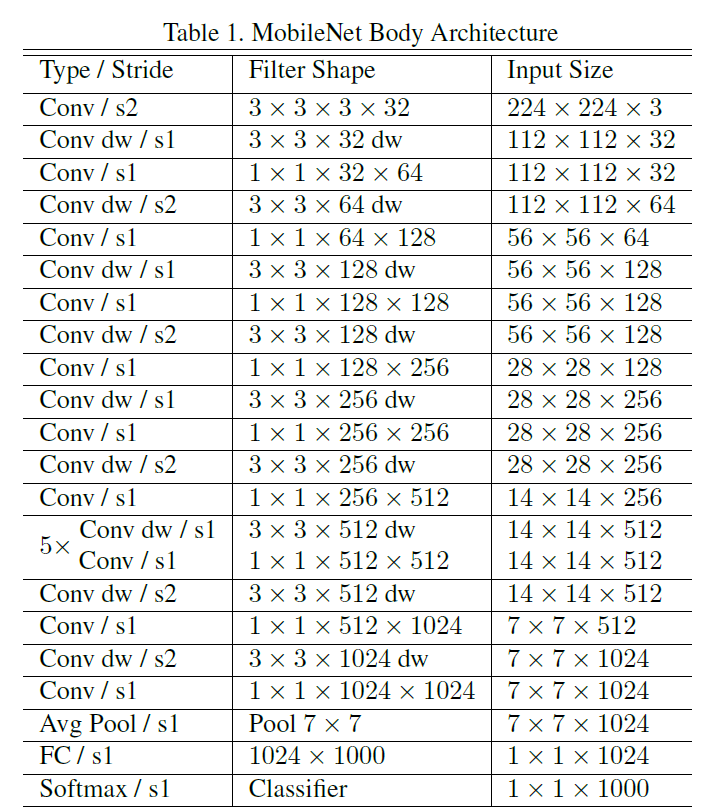

In [4]:
class MobileNet(nn.HybridBlock):
    def __init__(self, num_classes, n_devices=2, multiplier=1.0, **kwags):
        super(MobileNet, self).__init__(**kwags)
        self.net = nn.HybridSequential()
        self.net.add(ConvBlock(3, 32, 2, 1, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(32, 64, 1, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(64, 128, 2, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(128, 128, 1, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(128, 256, 2, n_devices, multiplier))

        self.net.add(DepthwiseSeperable(256, 256, 1, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(256, 512, 2, n_devices, multiplier))
        for _ in range(5):
            self.net.add(DepthwiseSeperable(512, 512, 1, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(512, 1024, 2, n_devices, multiplier))
        self.net.add(DepthwiseSeperable(1024, 1024, 1, n_devices, multiplier))

        self.net.add(nn.GlobalAvgPool2D())
        self.net.add(nn.Dense(num_classes))

    def hybrid_forward(self, F, x):
        return self.net(x)

* 模型维度检查：

In [9]:
net = MobileNet(num_classes=1000, n_devices=2, multiplier=1.0)
net.initialize(mx.init.Xavier())

In [10]:
test_input = nd.random_normal(shape=(1, 3, 224, 224))
net.summary(test_input)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 224, 224)               0
            Conv2D-1                           (1, 32, 112, 112)             864
     SyncBatchNorm-2                           (1, 32, 112, 112)             128
        Activation-3                           (1, 32, 112, 112)               0
         ConvBlock-4                           (1, 32, 112, 112)               0
            Conv2D-5                           (1, 32, 112, 112)             288
     SyncBatchNorm-6                           (1, 32, 112, 112)             128
        Activation-7                           (1, 32, 112, 112)               0
            Conv2D-8                           (1, 64, 112, 112)            2048
     SyncBatchNorm-9                           (1, 64, 112, 112)             256
       Activation-10        

* 刚开始模型训练结果很差，就和github上一个代码逐层做了下对比，后来发现pointwise convolution层忘记加BN了。

In [37]:
# from github_mobilenet import MobileNet
# net2 = MobileNet(classes=1000, num_sync_bn_devices=2)
# net2.initialize(init=mx.init.Xavier())
# test_input = nd.random_normal(shape=(1, 3, 224, 224))
# net2.summary(test_input)

* 使用mx.viz.plot_network进行可视化。  
注意：该接口接收的网络是symble类型的。因此需要将Gluon转为Symbol。这个技巧在训练神经网络时也非常有用，因为据说Symbol比Gluon快（即便进行了hybridize）  

* 参考：https://fiercex.github.io/post/gluon_to_symbol/

In [77]:
net.hybridize()
output = net.forward(test_input)
# export之后同时生成了一个.json文件和.params文件
net.export('Gluon-MobileNet')

In [59]:
symnet = mx.symbol.load('Gluon-MobileNet-symbol.json')

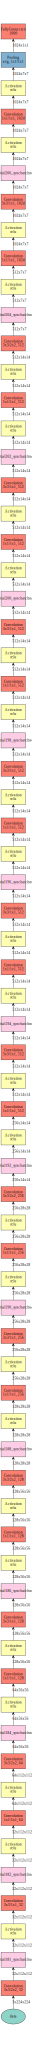

In [60]:
mx.viz.plot_network(symnet, title='mobilnet_viz', shape={'data':(1, 3, 224, 224)})

### Step2: Train on CIFAR10

In [13]:
from mxnet.gluon.data.vision.datasets import CIFAR10
import mxnet.gluon.data as gdata
from mxnet.gluon.model_zoo import vision
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.utils import split_and_load
from mxnet import autograd
import time

In [6]:
BATCH_SIZE = 128
naive_transform = transforms.ToTensor()
train_iter = gdata.DataLoader(CIFAR10().transform_first(naive_transform), batch_size=BATCH_SIZE, shuffle=True)
test_iter = gdata.DataLoader(CIFAR10(train=False).transform_first(naive_transform), batch_size=BATCH_SIZE)

# def naive_transform(data, label):
#     data = data.transpose((2,0,1))  # 原始尺寸：data.shape = (32, 32, 3)
#     return data.astype('float32')/255., label.astype('float32')
# train_iter = gdata.DataLoader(CIFAR10(transform=naive_transform),
#                         batch_size=128, shuffle=True, last_batch='rollover')
# test_iter = gdata.DataLoader(CIFAR10(train=False, transform=naive_transform),
#                         batch_size=128, shuffle=True, last_batch='rollover')

In [7]:
def evaluate(test_iter):
    metric_val = mx.metric.Accuracy()
    val_loss = 0
    for X, y in test_iter:
        X = split_and_load(X, ctx)
        y = split_and_load(y, ctx)
        outputs = [net(x) for x in X]
        loss = [criterion(output, target) for output, target in zip(outputs, y)]
        val_loss += sum([l.mean().asscalar() for l in loss])/len(ctx)
        metric_val.update(y, outputs)
    return metric_val.get()[1], val_loss/len(test_iter)

In [9]:
def train(model, trainer, criterion, ctx, batchSize, epochs, lr_decay_dict=None):
    metric = mx.metric.Accuracy()
    for epoch in range(EPOCHS):
        tic = time.time()
        metric.reset()
        train_loss_avg = 0
        for it, (X, y) in enumerate(train_iter):
            X = split_and_load(X, ctx)
            y = split_and_load(y, ctx)
            with autograd.record():
                logits = [net(x) for x in X]
                loss = [criterion(logit, label) for logit,label in zip(logits, y)]
            for l in loss:
                l.backward() 
            # 每个iteration将当期batch的平均loss加入loss_history
            train_loss_avg += sum([l.mean().asscalar() for l in loss])/2
            trainer.step(BATCH_SIZE)
            metric.update(y, logits)
        if lr_decay_dict is not None:
            if epoch in lr_decay_dict.keys():
                trainer.set_learning_rate(trainer.learning_rate * lr_decay_dict[epoch])
        name, accuracy = metric.get()
        val_acc, val_loss = evaluate(test_iter)
        print("Epoch {}, train_acc: {:.4f}, train_loss: {:.4f}, val_acc: {:.4f}, val_loss: {:.4f} epoch time: {:.4f}  lr: {:.6f}".format(
               epoch, accuracy, train_loss_avg/len(train_iter), val_acc, val_loss, time.time()-tic, trainer.learning_rate))
        if val_loss<0.7:
            model.save_parameters('best_params_acc_{:.4f}_loss_{:.4f}.params'.format(val_acc, val_loss))

In [9]:
from github_mobilenet import MobileNet

In [11]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 32
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = MobileNet(classes=10, num_sync_bn_devices=2, multiplier=1.0)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-3, 'momentum':0.9})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {10:0.5, 20:0.6, 40:0.5}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

Epoch 0, train_acc: 0.2868, train_loss: 1.9762, val_acc: 0.3563, val_loss: 1.8432 epoch time: 18.2612
Epoch 1, train_acc: 0.4135, train_loss: 1.6150, val_acc: 0.4413, val_loss: 1.5527 epoch time: 17.8403
Epoch 2, train_acc: 0.4704, train_loss: 1.4633, val_acc: 0.4864, val_loss: 1.4282 epoch time: 17.9698
Epoch 3, train_acc: 0.5088, train_loss: 1.3585, val_acc: 0.5019, val_loss: 1.3996 epoch time: 17.8298
Epoch 4, train_acc: 0.5407, train_loss: 1.2738, val_acc: 0.5065, val_loss: 1.3969 epoch time: 17.8623
Epoch 5, train_acc: 0.5698, train_loss: 1.2002, val_acc: 0.5230, val_loss: 1.3170 epoch time: 17.8079
Epoch 6, train_acc: 0.5920, train_loss: 1.1358, val_acc: 0.5340, val_loss: 1.3145 epoch time: 17.8922
Epoch 7, train_acc: 0.6166, train_loss: 1.0747, val_acc: 0.5412, val_loss: 1.3038 epoch time: 17.7676
Epoch 8, train_acc: 0.6370, train_loss: 1.0199, val_acc: 0.5402, val_loss: 1.3274 epoch time: 17.9085
Epoch 9, train_acc: 0.6592, train_loss: 0.9620, val_acc: 0.5487, val_loss: 1.3224 

Epoch 80, train_acc: 0.9865, train_loss: 0.0401, val_acc: 0.5955, val_loss: 2.7900 epoch time: 17.8712
Epoch 81, train_acc: 0.9871, train_loss: 0.0376, val_acc: 0.6005, val_loss: 2.7969 epoch time: 17.8455
Epoch 82, train_acc: 0.9865, train_loss: 0.0389, val_acc: 0.5945, val_loss: 2.8105 epoch time: 17.8103
Epoch 83, train_acc: 0.9871, train_loss: 0.0374, val_acc: 0.5825, val_loss: 2.8160 epoch time: 17.9332
Epoch 84, train_acc: 0.9883, train_loss: 0.0343, val_acc: 0.5915, val_loss: 2.8048 epoch time: 17.7482
Epoch 85, train_acc: 0.9890, train_loss: 0.0330, val_acc: 0.5915, val_loss: 2.8319 epoch time: 17.8975
Epoch 86, train_acc: 0.9872, train_loss: 0.0389, val_acc: 0.5975, val_loss: 2.8148 epoch time: 17.9172
Epoch 87, train_acc: 0.9885, train_loss: 0.0340, val_acc: 0.5971, val_loss: 2.8465 epoch time: 17.8555
Epoch 88, train_acc: 0.9860, train_loss: 0.0404, val_acc: 0.5915, val_loss: 2.8399 epoch time: 17.7586
Epoch 89, train_acc: 0.9868, train_loss: 0.0380, val_acc: 0.5921, val_los

In [9]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = MobileNet(num_classes=10, n_devices=2, multiplier=1.0)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-3, 'momentum':0.9})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {10:0.5, 20:0.6, 40:0.5}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

Epoch 0, train_acc: 0.2044, train_loss: 2.1803, val_acc: 0.2911, val_loss: 1.9404 epoch time: 24.7334
Epoch 1, train_acc: 0.3250, train_loss: 1.8303, val_acc: 0.3668, val_loss: 1.7297 epoch time: 16.7589
Epoch 2, train_acc: 0.3835, train_loss: 1.6704, val_acc: 0.4016, val_loss: 1.6145 epoch time: 17.0308
Epoch 3, train_acc: 0.4255, train_loss: 1.5590, val_acc: 0.4333, val_loss: 1.5304 epoch time: 17.6914
Epoch 4, train_acc: 0.4605, train_loss: 1.4735, val_acc: 0.4561, val_loss: 1.4702 epoch time: 17.6671
Epoch 5, train_acc: 0.4883, train_loss: 1.4051, val_acc: 0.4808, val_loss: 1.4154 epoch time: 17.6366
Epoch 6, train_acc: 0.5102, train_loss: 1.3429, val_acc: 0.4906, val_loss: 1.3905 epoch time: 17.6677
Epoch 7, train_acc: 0.5353, train_loss: 1.2820, val_acc: 0.5038, val_loss: 1.3697 epoch time: 17.4815
Epoch 8, train_acc: 0.5539, train_loss: 1.2344, val_acc: 0.5125, val_loss: 1.3483 epoch time: 17.5117
Epoch 9, train_acc: 0.5735, train_loss: 1.1850, val_acc: 0.5212, val_loss: 1.3404 

Epoch 80, train_acc: 0.9788, train_loss: 0.0621, val_acc: 0.5712, val_loss: 2.5466 epoch time: 17.5619
Epoch 81, train_acc: 0.9793, train_loss: 0.0604, val_acc: 0.5748, val_loss: 2.5858 epoch time: 17.6409
Epoch 82, train_acc: 0.9779, train_loss: 0.0664, val_acc: 0.5779, val_loss: 2.5392 epoch time: 17.6427
Epoch 83, train_acc: 0.9787, train_loss: 0.0614, val_acc: 0.5776, val_loss: 2.5184 epoch time: 17.4432
Epoch 84, train_acc: 0.9779, train_loss: 0.0648, val_acc: 0.5803, val_loss: 2.5518 epoch time: 17.6707
Epoch 85, train_acc: 0.9800, train_loss: 0.0599, val_acc: 0.5785, val_loss: 2.5416 epoch time: 17.5779
Epoch 86, train_acc: 0.9818, train_loss: 0.0562, val_acc: 0.5765, val_loss: 2.5691 epoch time: 17.5206
Epoch 87, train_acc: 0.9829, train_loss: 0.0513, val_acc: 0.5822, val_loss: 2.5337 epoch time: 17.5520
Epoch 88, train_acc: 0.9831, train_loss: 0.0505, val_acc: 0.5830, val_loss: 2.5579 epoch time: 17.4631
Epoch 89, train_acc: 0.9842, train_loss: 0.0475, val_acc: 0.5844, val_los

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_train_log(logpath, viz=True):
    df = pd.read_csv(logpath, delimiter='\t', index_col=False)
    plt.style.use('ggplot')
    df.columns = ["epoch", "train_acc","train_loss","val_acc","val_loss"]
    plt.plot(df['epoch'], df['train_loss'], label="train_loss")
    plt.plot(df['epoch'], df['train_acc'], label="train_acc")
    plt.plot(df['epoch'], df['val_loss'], label="val_loss")
    plt.plot(df['epoch'], df['val_acc'], label="val_acc")

    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    if viz: 
        plt.show() 
    else: 
        plt.savefig('loss_curve.png')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


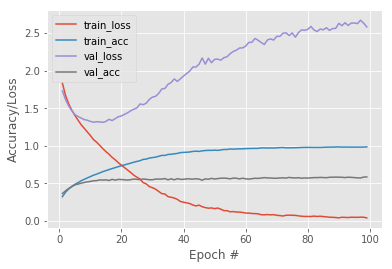

In [13]:
!cat train_1.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_1.csv
plot_train_log('train_1.csv')

In [15]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = MobileNet(num_classes=10, n_devices=2, multiplier=1.0)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-4, 'momentum':0.9})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {10:0.5, 20:0.6, 40:0.5}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

Epoch 0, train_acc: 0.1323, train_loss: 2.4408, val_acc: 0.1426, val_loss: 2.3678 epoch time: 17.6111
Epoch 1, train_acc: 0.1713, train_loss: 2.2669, val_acc: 0.1923, val_loss: 2.2267 epoch time: 17.6057
Epoch 2, train_acc: 0.1986, train_loss: 2.1696, val_acc: 0.2193, val_loss: 2.1293 epoch time: 17.4713
Epoch 3, train_acc: 0.2287, train_loss: 2.0739, val_acc: 0.2402, val_loss: 2.0377 epoch time: 17.3322
Epoch 4, train_acc: 0.2580, train_loss: 1.9838, val_acc: 0.2678, val_loss: 1.9421 epoch time: 17.3387
Epoch 5, train_acc: 0.2824, train_loss: 1.9164, val_acc: 0.2955, val_loss: 1.8886 epoch time: 17.4614
Epoch 6, train_acc: 0.3059, train_loss: 1.8574, val_acc: 0.3171, val_loss: 1.8245 epoch time: 17.6654
Epoch 7, train_acc: 0.3326, train_loss: 1.7987, val_acc: 0.3387, val_loss: 1.7675 epoch time: 17.4392
Epoch 8, train_acc: 0.3473, train_loss: 1.7576, val_acc: 0.3500, val_loss: 1.7412 epoch time: 17.4349
Epoch 9, train_acc: 0.3620, train_loss: 1.7119, val_acc: 0.3592, val_loss: 1.7078 

Epoch 80, train_acc: 0.7528, train_loss: 0.7061, val_acc: 0.4837, val_loss: 1.6890 epoch time: 17.5220
Epoch 81, train_acc: 0.7638, train_loss: 0.6857, val_acc: 0.4843, val_loss: 1.6698 epoch time: 17.5252
Epoch 82, train_acc: 0.7663, train_loss: 0.6810, val_acc: 0.4838, val_loss: 1.7117 epoch time: 17.5714
Epoch 83, train_acc: 0.7676, train_loss: 0.6662, val_acc: 0.4794, val_loss: 1.7112 epoch time: 17.5734
Epoch 84, train_acc: 0.7722, train_loss: 0.6557, val_acc: 0.4853, val_loss: 1.7153 epoch time: 17.5089
Epoch 85, train_acc: 0.7778, train_loss: 0.6420, val_acc: 0.4857, val_loss: 1.7276 epoch time: 17.4888
Epoch 86, train_acc: 0.7808, train_loss: 0.6307, val_acc: 0.4855, val_loss: 1.7337 epoch time: 17.4348
Epoch 87, train_acc: 0.7839, train_loss: 0.6281, val_acc: 0.4864, val_loss: 1.7380 epoch time: 17.6142
Epoch 88, train_acc: 0.7890, train_loss: 0.6114, val_acc: 0.4866, val_loss: 1.7382 epoch time: 17.4588
Epoch 89, train_acc: 0.7931, train_loss: 0.6025, val_acc: 0.4840, val_los

In [15]:
## 比较了下自己实现的MobileNet和官方的MobileNet的summary，一致。
from mxnet.gluon.model_zoo import vision
official_mobilenet = vision.mobilenet1_0()
official_mobilenet.initialize(mx.init.Xavier())
official_mobilenet.summary(test_input)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 224, 224)               0
            Conv2D-1                           (1, 32, 112, 112)             864
         BatchNorm-2                           (1, 32, 112, 112)             128
        Activation-3                           (1, 32, 112, 112)               0
            Conv2D-4                           (1, 32, 112, 112)             288
         BatchNorm-5                           (1, 32, 112, 112)             128
        Activation-6                           (1, 32, 112, 112)               0
            Conv2D-7                           (1, 64, 112, 112)            2048
         BatchNorm-8                           (1, 64, 112, 112)             256
        Activation-9                           (1, 64, 112, 112)               0
           Conv2D-10        

In [27]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = vision.mobilenet1_0(classes=10)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-3, 'momentum':0.9})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {10:0.5, 20:0.6, 40:0.5}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

Epoch 0, train_acc: 0.2046, train_loss: 2.1983, val_acc: 0.2835, val_loss: 1.9946 epoch time: 21.2383
Epoch 1, train_acc: 0.3086, train_loss: 1.8778, val_acc: 0.3451, val_loss: 1.7876 epoch time: 13.8042
Epoch 2, train_acc: 0.3660, train_loss: 1.7224, val_acc: 0.3932, val_loss: 1.6656 epoch time: 13.7469
Epoch 3, train_acc: 0.4046, train_loss: 1.6189, val_acc: 0.4244, val_loss: 1.5706 epoch time: 13.6735
Epoch 4, train_acc: 0.4361, train_loss: 1.5377, val_acc: 0.4517, val_loss: 1.4999 epoch time: 13.7596
Epoch 5, train_acc: 0.4641, train_loss: 1.4693, val_acc: 0.4618, val_loss: 1.4744 epoch time: 13.7172
Epoch 6, train_acc: 0.4864, train_loss: 1.4144, val_acc: 0.4719, val_loss: 1.4425 epoch time: 13.7233
Epoch 7, train_acc: 0.5064, train_loss: 1.3608, val_acc: 0.4950, val_loss: 1.4025 epoch time: 13.7818
Epoch 8, train_acc: 0.5249, train_loss: 1.3157, val_acc: 0.4992, val_loss: 1.3820 epoch time: 13.8962
Epoch 9, train_acc: 0.5384, train_loss: 1.2838, val_acc: 0.5093, val_loss: 1.3631 

KeyboardInterrupt: 

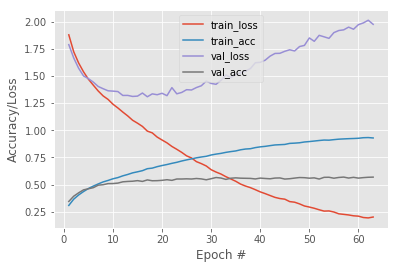

In [30]:
!cat train_official.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_official.csv
plot_train_log('train_official.csv')

In [ ]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = vision.mobilenet0_75(classes=10)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':1e-3, 'momentum':0.9})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {10:0.5, 20:0.6, 40:0.5}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

In [32]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = vision.mobilenet1_0(classes=10)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':1e-2})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    lr_decay_dict = {20:0.1, 45:0.1}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS)

Epoch 0, train_acc: 0.3275, train_loss: 1.9606, val_acc: 0.4205, val_loss: 1.6530 epoch time: 14.7065
Epoch 1, train_acc: 0.4652, train_loss: 1.4808, val_acc: 0.5063, val_loss: 1.3906 epoch time: 14.3991
Epoch 2, train_acc: 0.5508, train_loss: 1.2627, val_acc: 0.5950, val_loss: 1.1241 epoch time: 14.5706
Epoch 3, train_acc: 0.6072, train_loss: 1.1091, val_acc: 0.6005, val_loss: 1.1295 epoch time: 14.4331
Epoch 4, train_acc: 0.6523, train_loss: 0.9972, val_acc: 0.6385, val_loss: 1.0320 epoch time: 14.5504
Epoch 5, train_acc: 0.6796, train_loss: 0.9141, val_acc: 0.6794, val_loss: 0.9320 epoch time: 14.5483
Epoch 6, train_acc: 0.7092, train_loss: 0.8385, val_acc: 0.6847, val_loss: 0.9178 epoch time: 14.5620
Epoch 7, train_acc: 0.7322, train_loss: 0.7710, val_acc: 0.7076, val_loss: 0.8279 epoch time: 14.6542
Epoch 8, train_acc: 0.7490, train_loss: 0.7279, val_acc: 0.7058, val_loss: 0.8726 epoch time: 14.5022
Epoch 9, train_acc: 0.7641, train_loss: 0.6819, val_acc: 0.7031, val_loss: 0.8833 

KeyboardInterrupt: 

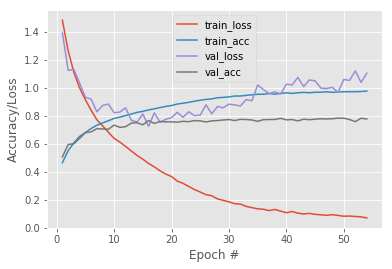

In [33]:
!cat train_075.log | awk -F ", |: | +" '{print $2"\t"$4"\t"$6"\t"$8"\t"$10}' > train_075.csv
plot_train_log('train_075.csv')

In [34]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = vision.mobilenet1_0(classes=10)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':1e-2})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    lr_decay_dict = {15:0.1, 30:0.1}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS, lr_decay_dict=lr_decay_dict)

Epoch 0, train_acc: 0.3276, train_loss: 1.9480, val_acc: 0.3778, val_loss: 1.8872 epoch time: 15.1018
Epoch 1, train_acc: 0.4792, train_loss: 1.4364, val_acc: 0.4980, val_loss: 1.4004 epoch time: 14.4880
Epoch 2, train_acc: 0.5620, train_loss: 1.2248, val_acc: 0.5750, val_loss: 1.2047 epoch time: 14.6199
Epoch 3, train_acc: 0.6235, train_loss: 1.0687, val_acc: 0.6199, val_loss: 1.1185 epoch time: 14.3969
Epoch 4, train_acc: 0.6631, train_loss: 0.9648, val_acc: 0.6530, val_loss: 0.9856 epoch time: 14.4871
Epoch 5, train_acc: 0.6947, train_loss: 0.8797, val_acc: 0.6706, val_loss: 0.9674 epoch time: 14.4569
Epoch 6, train_acc: 0.7219, train_loss: 0.8116, val_acc: 0.6759, val_loss: 0.9410 epoch time: 14.6097
Epoch 7, train_acc: 0.7401, train_loss: 0.7579, val_acc: 0.6934, val_loss: 0.8999 epoch time: 14.5539
Epoch 8, train_acc: 0.7593, train_loss: 0.7077, val_acc: 0.7106, val_loss: 0.8501 epoch time: 14.4595
Epoch 9, train_acc: 0.7733, train_loss: 0.6674, val_acc: 0.7265, val_loss: 0.8168 

KeyboardInterrupt: 

In [10]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = MobileNet(10)
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':1e-2})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    lr_decay_dict = {15:0.05, 25:0.1}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS, lr_decay_dict=lr_decay_dict)

Epoch 0, train_acc: 0.3202, train_loss: 1.9426, val_acc: 0.4232, val_loss: 1.5804 epoch time: 25.2319  lr: 0.010000
Epoch 1, train_acc: 0.4804, train_loss: 1.4330, val_acc: 0.5203, val_loss: 1.3455 epoch time: 17.8703  lr: 0.010000
Epoch 2, train_acc: 0.5608, train_loss: 1.2292, val_acc: 0.5563, val_loss: 1.2580 epoch time: 18.0096  lr: 0.010000
Epoch 3, train_acc: 0.6009, train_loss: 1.1260, val_acc: 0.5964, val_loss: 1.1335 epoch time: 18.3458  lr: 0.010000
Epoch 4, train_acc: 0.6385, train_loss: 1.0284, val_acc: 0.6284, val_loss: 1.0678 epoch time: 18.1178  lr: 0.010000
Epoch 5, train_acc: 0.6681, train_loss: 0.9485, val_acc: 0.6121, val_loss: 1.1300 epoch time: 17.9784  lr: 0.010000
Epoch 6, train_acc: 0.6940, train_loss: 0.8840, val_acc: 0.6344, val_loss: 1.0813 epoch time: 18.1433  lr: 0.010000
Epoch 7, train_acc: 0.7108, train_loss: 0.8237, val_acc: 0.6858, val_loss: 0.9230 epoch time: 18.2159  lr: 0.010000
Epoch 8, train_acc: 0.7344, train_loss: 0.7671, val_acc: 0.6812, val_los

Epoch 71, train_acc: 0.9984, train_loss: 0.0061, val_acc: 0.7642, val_loss: 1.7284 epoch time: 18.2619  lr: 0.000050
Epoch 72, train_acc: 0.9982, train_loss: 0.0062, val_acc: 0.7651, val_loss: 1.7477 epoch time: 18.0962  lr: 0.000050
Epoch 73, train_acc: 0.9986, train_loss: 0.0054, val_acc: 0.7625, val_loss: 1.7590 epoch time: 18.1835  lr: 0.000050
Epoch 74, train_acc: 0.9984, train_loss: 0.0055, val_acc: 0.7626, val_loss: 1.7573 epoch time: 18.1756  lr: 0.000050
Epoch 75, train_acc: 0.9983, train_loss: 0.0057, val_acc: 0.7655, val_loss: 1.7615 epoch time: 18.1881  lr: 0.000050
Epoch 76, train_acc: 0.9981, train_loss: 0.0062, val_acc: 0.7642, val_loss: 1.7757 epoch time: 18.2081  lr: 0.000050
Epoch 77, train_acc: 0.9985, train_loss: 0.0052, val_acc: 0.7616, val_loss: 1.7737 epoch time: 18.2049  lr: 0.000050
Epoch 78, train_acc: 0.9983, train_loss: 0.0058, val_acc: 0.7642, val_loss: 1.7844 epoch time: 18.2022  lr: 0.000050
Epoch 79, train_acc: 0.9984, train_loss: 0.0055, val_acc: 0.7631

In [ ]:
if __name__ == "__main__":
    EPOCHS = 100
    BATCH_SIZE = 128
    ctx = [mx.gpu(0), mx.gpu(1)]
    
    net = vision.mobilenet_v2_1_0()
    net.initialize(init=mx.init.Xavier(), ctx=ctx)
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate':1e-2})
    criterion = gluon.loss.SoftmaxCrossEntropyLoss()
    #lr_decay_dict = {15:0.05, 25:0.1}
    train(net, trainer, criterion, ctx, BATCH_SIZE, EPOCHS, lr_decay_dict=lr_decay_dict)

Epoch 0, train_acc: 0.2316, train_loss: 2.1403, val_acc: 0.3102, val_loss: 1.7688 epoch time: 24.0784  lr: 0.010000
Epoch 1, train_acc: 0.3808, train_loss: 1.6318, val_acc: 0.4280, val_loss: 1.5677 epoch time: 23.3393  lr: 0.010000
Epoch 2, train_acc: 0.4738, train_loss: 1.4368, val_acc: 0.4872, val_loss: 1.4995 epoch time: 23.4019  lr: 0.010000


In [ ]:
dataset_train = CIFAR10()
    dataset_test = CIFAR10(train=False)
    trans_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(32,32)),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=0.1, contrast=0.1, 
                                 saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2023, 0.1994, 0.2010]),
        ])
    trans_test = transforms.Compose([
        transforms.ToTensor()
        ])
    train_iter = gdata.DataLoader(dataset_train.transform_first(trans_train),
                            batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)
    test_iter = gdata.DataLoader(dataset_test.transform_first(trans_test),
                            batch_size=128, shuffle=True, last_batch='rollover', num_workers=-1)